In [1]:
import pandas as pd
import numpy as np
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
from sklearn.preprocessing import MinMaxScaler
import time
import warnings
warnings.simplefilter('ignore')
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()

# load data

In [2]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag_map = dict(zip(tag.TAG,tag.chinese))
tag[tag.category=='可控制因子']

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1.0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,140,160,***
1,2.0,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3.0,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,30,90,****
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5.0,MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****
5,6.0,MLPAP_PIC-0741.PV,汽鼓(V211)鍋爐水壓力,壓力,KG/CM2,可控制因子,1分鐘2筆,0,30.05,*
6,7.0,MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,液位,%,可控制因子,1分鐘2筆,20,60,*
7,8.0,MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,壓力,BAR,可控制因子,1分鐘2筆,40,55,***
8,9.0,MLPAP_TRC-0762.PV,鹽浴冷卻器(E112)入口溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,***
9,10.0,MLPAP_LRC-0729.PV,鍋爐水液位控制,液位,%,可控制因子,1分鐘2筆,20,60,*


In [3]:
df = pd.read_csv('../data/train_cleaned.csv',index_col=0,parse_dates=True)
print(df.shape)
df.sample(5)

(193824, 95)


,MLPAP_TJ-0706B02,MLPAP_TJ-0706B03,MLPAP_TJ-0706B04,MLPAP_TJ-0706B05,MLPAP_TJ-0706B06,MLPAP_TJ-0706B07,MLPAP_TJ-0706B08,MLPAP_TJ-0706B09,MLPAP_TJ-0706B10,MLPAP_TJ-0706B11,...,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TJC-0757.PV,MLPAP_V225-PHD,MLPAP_PI-0771.PV,MLPAP_TRC-0747.PV,Unnamed: 96,MLPAP_TRC-0497.PV
2019-04-20 16:00:00,382.174973,397.004257,400.000000,404.249756,401.000000,401.974976,401.400314,398.124786,397.0,394.0,...,8.537631,32.116802,6605.855713,495.283585,0.210727,0.018,118.098549,169.000343,NaN,8601.176270
2018-05-06 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.148797,NaN,NaN,NaN,NaN,0.032,NaN,132.650002,NaN,0.000000
2017-11-24 15:10:00,379.401886,398.102585,404.000000,410.050156,405.488892,406.000000,403.744781,406.000000,405.0,401.0,...,18.806600,29.638542,NaN,469.758774,-0.246902,0.027,143.566711,171.733246,NaN,7920.653320
2019-02-03 15:20:00,380.000000,397.000000,400.923523,405.034668,402.558243,403.000000,401.250122,399.000000,397.0,394.0,...,9.506689,32.404392,6621.953857,NaN,0.284543,0.003,118.546124,169.599998,NaN,0.000000
2018-02-02 08:30:00,379.000000,397.199982,403.000000,409.039566,404.974915,405.000000,402.949890,405.000000,404.0,400.0,...,17.182530,30.748601,NaN,483.606674,0.152532,0.024,163.011421,172.800003,NaN,8572.338379


# add total_stream

In [4]:
stream_cols = tag[tag.chinese.str.contains('蒸氣')== True].TAG.tolist()
print(stream_cols)
df['stream'] = df[stream_cols[0]]*1000 + df[stream_cols[1]]*1000
df['stream'].describe()

['MLPAP_FR-0755PV(轉換後)', 'MLPAP_FR-0791.PV', 'MLPAP_FI-V211.PV(轉換後)']


count    139591.000000
mean      44226.495198
std        5268.458119
min       13978.628516
25%       41200.861692
50%       45574.576378
75%       48101.296186
max       49620.235443
Name: stream, dtype: float64

# add new features

In [5]:
df['濃度'] = df['MLPAP_FQ-0619.PV']*df['MLPAP_FR-0632.PV']

# define columns

In [6]:
action = tag[tag['category']=='可控制因子']['TAG'].values.tolist()
action = action + ['濃度']

# delete not need columns
action.remove('MLPAP_FQ-0619.PV')
action.remove('MLPAP_TJC-0757.PV')
action.remove('MLPAP_PIC-0741.PV')
action.remove('MLPAP_LIC-0738.PV')
action.remove('MLPAP_TRC-0762.PV')
action.remove('MLPAP_LRC-0729.PV')
action.insert(0,'MLPAP_FQ-0619.PV')
print('action:',len(action))

action: 11


In [7]:
output = get_col(df,'0997')
print('output:',len(output))

output: 1


In [8]:
stream = ['stream']
print('stream:',len(stream))

stream: 1


In [9]:
state = get_col(df,'DATA OF USE')
print('state:',len(state))

state: 1


# select columns

In [10]:
df = df[state + action + output + stream]
print(df.shape)

(193824, 14)


# look miss value

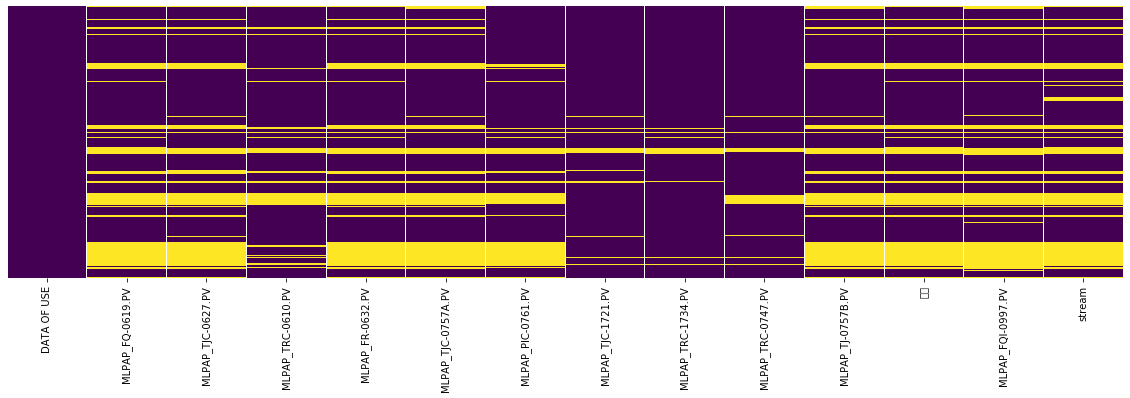

In [11]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# scale data

In [12]:
mm_state = MinMaxScaler()
mm_action = MinMaxScaler()
mm_output = MinMaxScaler()
mm_stream = MinMaxScaler()

df[state] = mm_state.fit_transform(df[state])
df[action] = mm_action.fit_transform(df[action])
df[output] = mm_output.fit_transform(df[output])
df[stream] = mm_stream.fit_transform(df[stream])

df.sample(5)

,DATA OF USE,MLPAP_FQ-0619.PV,MLPAP_TJC-0627.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_TJC-0757A.PV,MLPAP_PIC-0761.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TRC-0747.PV,MLPAP_TJ-0757B.PV,濃度,MLPAP_FQI-0997.PV,stream
2019-10-09 18:40:00,0.927761,NaN,NaN,0.470143,NaN,NaN,NaN,0.272302,0.321772,0.410888,NaN,NaN,NaN,NaN
2018-05-15 18:10:00,0.547289,0.462463,0.422635,0.675578,0.805471,0.231430,0.922533,0.301107,0.407121,0.987049,0.269545,0.412902,NaN,0.530566
2016-12-13 01:00:00,0.161842,0.892382,0.007210,0.532759,0.837999,0.000426,0.977252,0.469762,0.284403,0.883262,0.068212,0.780793,0.695691,0.881197
2019-02-23 15:50:00,0.758251,0.944463,0.758911,0.557976,0.955514,0.212932,0.944559,0.269317,0.321055,0.850203,0.231582,0.915081,0.742334,0.749831
2018-04-02 06:10:00,0.514965,0.963961,0.423154,0.620436,0.955498,0.213597,0.944024,0.303621,0.249775,0.882505,0.248528,0.932372,0.776295,0.974393


# build dataset for modeling

In [13]:
def build_dataset(df,n):
    
    data = {'state':[],
            'action':[],
            'output':[],
            'stream':[],
            'idx':[]}
    
    for i in tqdm(range(0,len(df)-n)):
        curr = df.iloc[i:i+n] #一小段資料
        if np.isnan(curr.values).sum() == 0: #確保這段資料無缺失值
            
            data['state'].append(curr[state].values.mean())#這段時間的觸媒使用時間 均值
            data['action'].append(curr[action].values)# 這段時間 "所有" 操作
            data['output'].append(curr[output].values[-1])#這段時間 最後一個時間點 的出料(delay issue)
            data['stream'].append(curr[stream].values[-1])#這段時間 最後一個時間點 的蒸氣(delay issue)
            data['idx'].append(curr.index[-1]) #這段時間最後 出料對應的時間點
    
    # reshape
    data['state'] = np.array(data['state']).reshape(-1,1)
    data['action'] = np.array(data['action'])
    data['output'] = np.array(data['output']).reshape(-1,1)
    data['stream'] = np.array(data['stream']).reshape(-1,1)
    
    # store scaler
    data['mm_state'] = mm_state
    data['mm_action'] = mm_action
    data['mm_output'] = mm_output
    data['mm_stream'] = mm_stream
    
    # store col_name
    data['state_col'] = state
    data['action_col'] = action
    data['output_col'] = output
    data['stream_col'] = stream
    
    return data

In [14]:
data = build_dataset(df,36)

In [15]:
print(len(data['idx']))

127660


# save

In [16]:
joblib.dump(data,'../data/dataset.pkl')

['../data/dataset.pkl']